# Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Good for non-normal features
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge # Regularized linear model

In [2]:
# For reproducibility
SEED = 42
np.random.seed(SEED)

# Set some display options for pandas
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Setup Complete!")

Setup Complete!


# Load Data

In [3]:
try:
    train_df = pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
    test_df = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
    sample_submission_df = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")
except FileNotFoundError:
    print("One or more data files not found. Please check paths.")

In [4]:
print(train_df.shape)
train_df.head()

(750000, 9)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [5]:
print(test_df.shape)
test_df.head()

(250000, 8)


,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


In [6]:
print(sample_submission_df.shape)
sample_submission_df.head()

(250000, 2)


,id,Calories
0,750000,88.283
1,750001,88.283
2,750002,88.283
3,750003,88.283
4,750004,88.283


# Initial Exploratory Data Analysis

In [7]:
# Target Variable
TARGET_COL = 'Calories'

In [8]:
# Basic info
print("\nTrain Info:")
train_df.info()
print("\nTest Info:")
test_df.info()


Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB

Test Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250

In [9]:
# Descriptive statistics
print("\nTrain Describe:")
print(train_df.describe().T) # Transpose for better readability



Train Describe:
               count           mean            std    min        25%  \
id          750000.0  374999.500000  216506.495284    0.0  187499.75   
Age         750000.0      41.420404      15.175049   20.0      28.00   
Height      750000.0     174.697685      12.824496  126.0     164.00   
Weight      750000.0      75.145668      13.982704   36.0      63.00   
Duration    750000.0      15.421015       8.354095    1.0       8.00   
Heart_Rate  750000.0      95.483995       9.449845   67.0      88.00   
Body_Temp   750000.0      40.036253       0.779875   37.1      39.60   
Calories    750000.0      88.282781      62.395349    1.0      34.00   

                 50%        75%       max  
id          374999.5  562499.25  749999.0  
Age             40.0      52.00      79.0  
Height         174.0     185.00     222.0  
Weight          74.0      87.00     132.0  
Duration        15.0      23.00      30.0  
Heart_Rate      95.0     103.00     128.0  
Body_Temp       40.3      

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Calories')

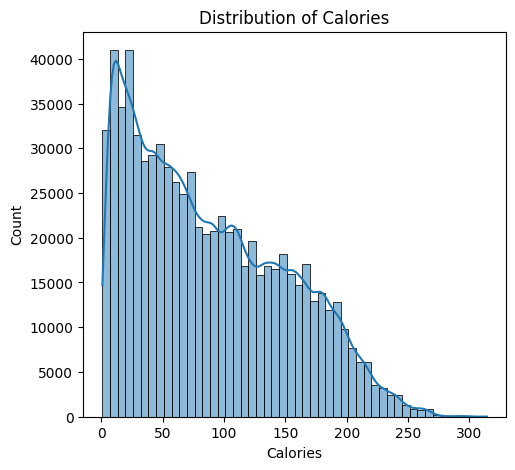

In [10]:
# --- 3.1. Target Variable Analysis ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(train_df[TARGET_COL], kde=True, bins=50)
plt.title(f'Distribution of {TARGET_COL}')

In [11]:
# (target + 1 to handle potential 0 values, though Calories should be > 0)
train_df[f'log1p_{TARGET_COL}'] = np.log1p(train_df[TARGET_COL])

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


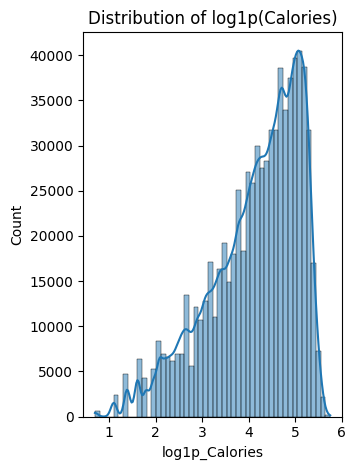

In [12]:
plt.subplot(1, 2, 2)
sns.histplot(train_df[f'log1p_{TARGET_COL}'], kde=True, bins=50)
plt.title(f'Distribution of log1p({TARGET_COL})')
plt.tight_layout()
plt.show()

In [13]:
# --- 3.2. Missing Values ---
print("\nMissing values in train_df:")
print(train_df.isnull().sum()[train_df.isnull().sum() > 0])
print("\nMissing values in test_df:")
print(test_df.isnull().sum()[test_df.isnull().sum() > 0])
# If there are missing values, we'll need an imputation strategy.


Missing values in train_df:
Series([], dtype: int64)

Missing values in test_df:
Series([], dtype: int64)


In [14]:

# --- 3.3. Feature Distributions (Numerical) ---
numerical_features = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_features = [col for col in numerical_features if col not in ['id', TARGET_COL, f'log1p_{TARGET_COL}']]



Plotting distributions for numerical features: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']


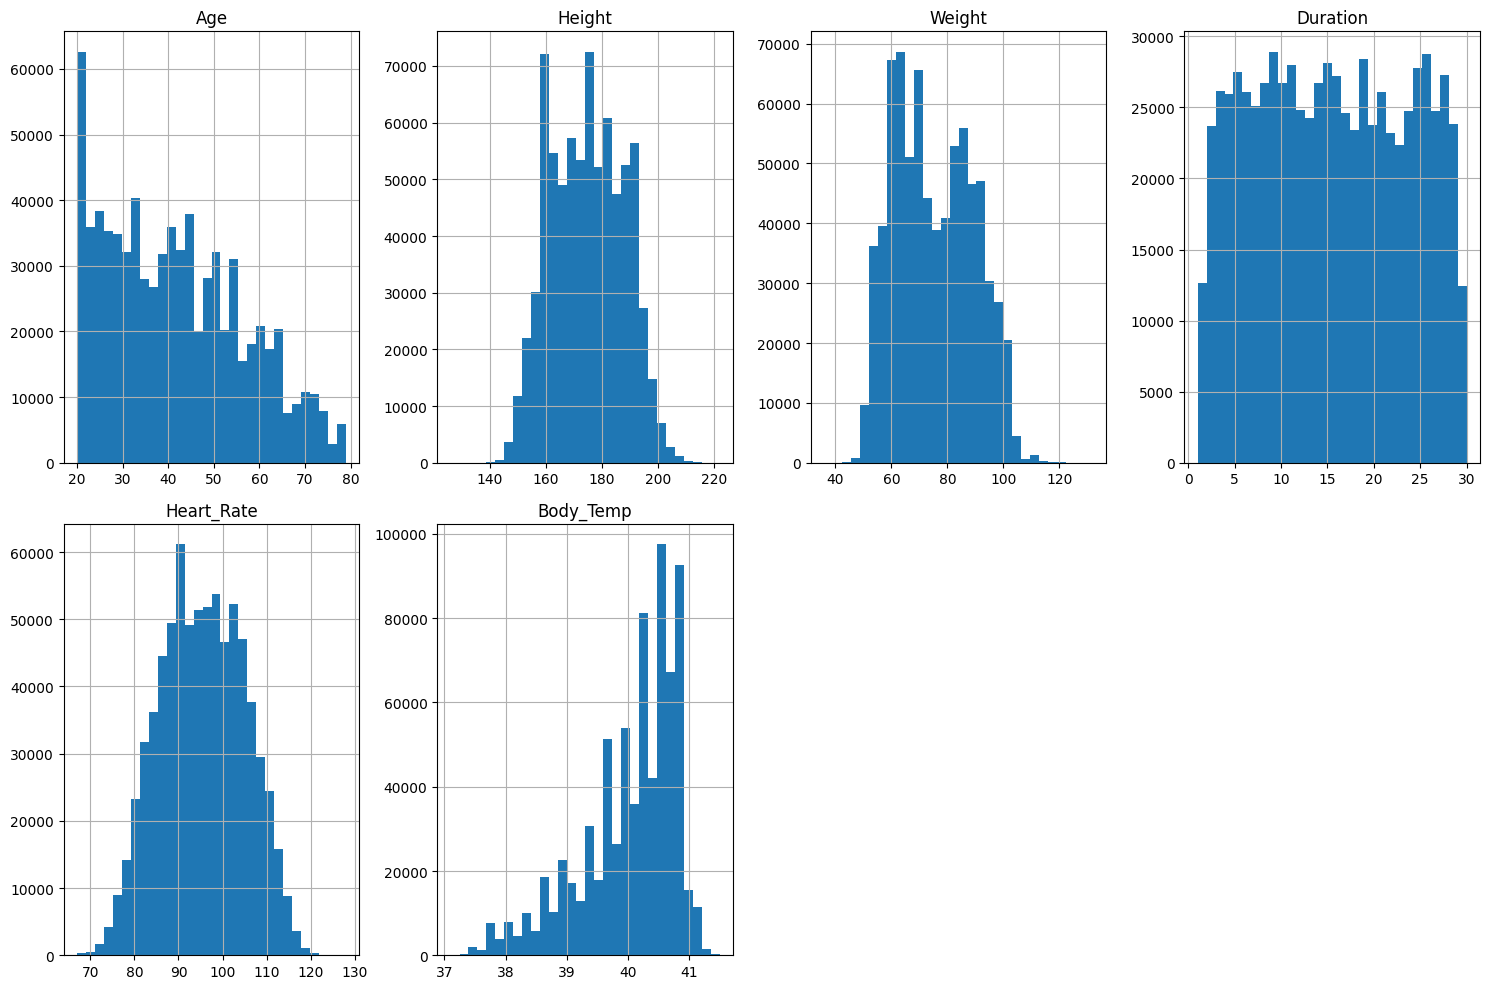

In [15]:
if numerical_features: # Check if the list is not empty
    print(f"\nPlotting distributions for numerical features: {numerical_features}")
    train_df[numerical_features].hist(bins=30, figsize=(15, 10), layout=(-1, 4))
    plt.tight_layout()
    plt.show()
else:
    print("No numerical features identified for plotting (excluding id and target).")

In [16]:

# --- 3.4. Categorical Features (if any) ---
# Playground series often have anonymized features (F1, F2, etc.) which might be numeric or categorical.
# If there are object columns, they are categorical.
categorical_features = train_df.select_dtypes(include='object').columns.tolist()
if categorical_features:
    print(f"\nCategorical features: {categorical_features}")
    for col in categorical_features:
        print(f"\nValue counts for {col}:")
        print(train_df[col].value_counts(dropna=False))
        # You might want to visualize these with sns.countplot
else:
    print("\nNo obvious categorical (object type) features found.")
    # Sometimes integer columns are actually categorical (e.g., 0/1 flags, or distinct low-cardinality values)
    # Example: Check for low cardinality integer features
    potential_cat_from_int = []
    for col in numerical_features:
        if train_df[col].nunique() < 20: # Arbitrary threshold for "low cardinality"
            potential_cat_from_int.append(col)
            print(f"Feature '{col}' has {train_df[col].nunique()} unique values. Could be categorical.")
            print(train_df[col].value_counts().sort_index())
    if not potential_cat_from_int:
        print("No low-cardinality integer features identified as potentially categorical.")



Categorical features: ['Sex']

Value counts for Sex:
Sex
female    375721
male      374279
Name: count, dtype: int64


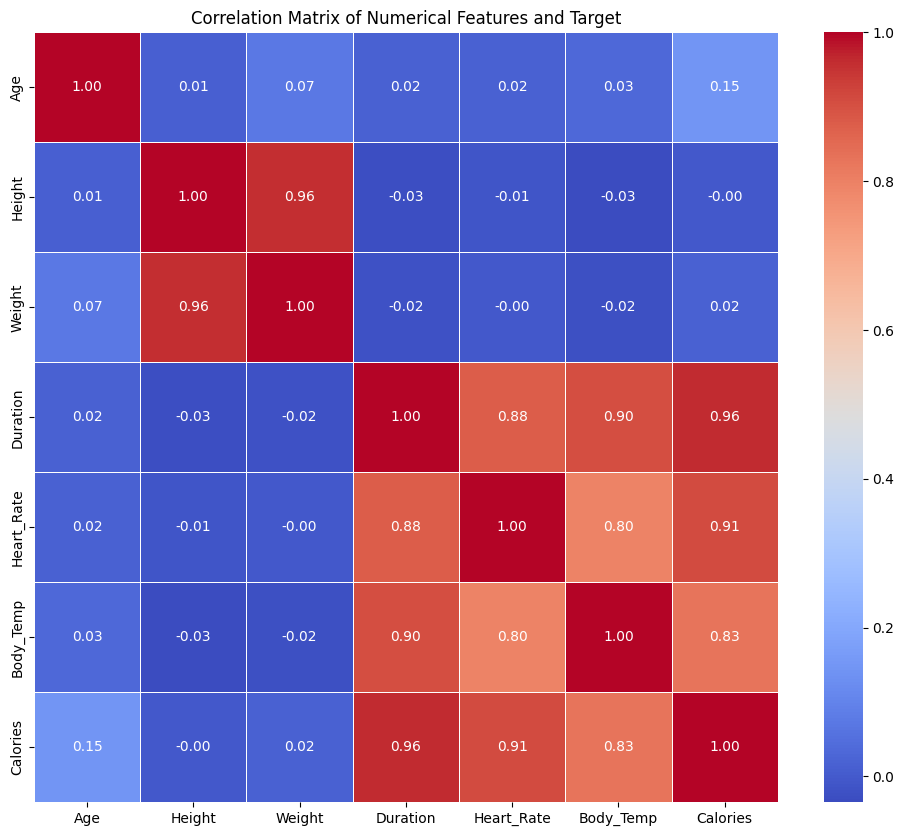


Correlations with Calories:
Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Name: Calories, dtype: float64


In [17]:
# --- 3.5. Correlation Analysis ---
# Only include numerical features for standard correlation
corr_features = numerical_features + [TARGET_COL] # Use original target for correlation interpretability
correlation_matrix = train_df[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features and Target')
plt.show()

# Correlations with the target variable
print(f"\nCorrelations with {TARGET_COL}:")
print(correlation_matrix[TARGET_COL].sort_values(ascending=False))


#  FEATURE ENGINEERING & PREPROCESSING

In [18]:
# --- 4.1. Define Features (X) and Target (y) ---
y = train_df[f'log1p_{TARGET_COL}']
# Drop id, target, and log-transformed target from train features
X_features_train = train_df.drop(['id', TARGET_COL, f'log1p_{TARGET_COL}'], axis=1)
# Drop only id from test features
X_features_test = test_df.drop('id', axis=1)

In [19]:
# --- 4.2. Identify Column Types ---
numerical_cols = X_features_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_features_train.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns for preprocessing: {numerical_cols}")
print(f"Categorical columns for preprocessing: {categorical_cols}")


Numerical columns for preprocessing: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
Categorical columns for preprocessing: ['Sex']


In [20]:
# --- 4.3. Create Preprocessing Pipelines ---
# Pipeline for numerical features: Impute (if needed) then Scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Handles potential future NaNs
    ('scaler', StandardScaler())
])

# Pipeline for categorical features: Impute (if needed) then OneHotEncode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Handles potential future NaNs
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])


In [21]:
# --- 4.4. Create ColumnTransformer ---
# Apply specific transformers to corresponding columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep any columns not specified (should be none here)
)

In [22]:

# --- 4.5. Apply Preprocessing ---
# Fit on training data and transform both train and test sets
X = preprocessor.fit_transform(X_features_train)
X_test_submit = preprocessor.transform(X_features_test)


In [23]:

# --- 4.6. Get Feature Names After Transformation (Optional but Recommended) ---
try:
    # Get feature names from numerical transformer (they remain the same relative order)
    num_feature_names = numerical_cols
    # Get feature names from categorical transformer after one-hot encoding
    cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
    # Combine feature names
    processed_feature_names = list(num_feature_names) + list(cat_feature_names)

    # If remainder='passthrough' kept columns, add their names (adjust if needed)
    # Example: Get column indices passed through
    # passthrough_indices = [i for i, trans in enumerate(preprocessor.transformers_) if trans[0] == 'remainder']
    # passthrough_features = X_features_train.columns[preprocessor.transformers_[passthrough_indices[0]][2]].tolist() if passthrough_indices else []
    # processed_feature_names += passthrough_features

    # Convert back to DataFrame if shapes match
    if X.shape[1] == len(processed_feature_names):
        X = pd.DataFrame(X, columns=processed_feature_names, index=X_features_train.index)
        X_test_submit = pd.DataFrame(X_test_submit, columns=processed_feature_names, index=X_features_test.index)
        print("Converted preprocessed data back to DataFrame with feature names.")
    else:
         print(f"Warning: Shape mismatch after preprocessing. X.shape[1]={X.shape[1]}, len(processed_feature_names)={len(processed_feature_names)}")
         print("Proceeding with NumPy arrays. Feature names might be generic for model importances.")

except Exception as e:
    print(f"Error getting feature names from ColumnTransformer: {e}")
    print("Proceeding with NumPy arrays for X and X_test_submit.")


print("\nPreprocessing complete. Shapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test_submit shape:", X_test_submit.shape)
if isinstance(X, pd.DataFrame):
    print("\nX head after preprocessing:")
    print(X.head())

Converted preprocessed data back to DataFrame with feature names.

Preprocessing complete. Shapes:
X shape: (750000, 8)
y shape: (750000,)
X_test_submit shape: (250000, 8)

X head after preprocessing:
        Age    Height    Weight  Duration  Heart_Rate  Body_Temp  Sex_female  \
0 -0.357192  1.115235  0.490201  1.266324    0.583714   1.235772         0.0   
1  1.487943 -0.912137 -1.083172 -0.888309   -1.109436  -0.431163         1.0   
2  0.631273 -1.068088 -0.797104 -1.008011   -1.215258  -0.302938         1.0   
3 -1.411555  1.349162  1.062337  1.146622    1.007002   0.851095         0.0   
4 -0.225397 -0.678209 -1.011655  1.146622    0.689536   0.722869         1.0   

   Sex_male  
0       1.0  
1       0.0  
2       0.0  
3       1.0  
4       0.0  


# MODEL TRAINING & VALIDATION

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")


X_train shape: (600000, 8), X_val shape: (150000, 8)
y_train shape: (600000,), y_val shape: (150000,)


In [25]:
def rmsle(y_true_log, y_pred_log):
    y_true_orig = np.expm1(y_true_log)
    y_pred_orig = np.expm1(y_pred_log)
    y_pred_orig = np.maximum(0, y_pred_orig) # Ensure non-negative predictions
    return np.sqrt(mean_squared_log_error(y_true_orig, y_pred_orig))

In [26]:

lgbm_params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': SEED,
    'boosting_type': 'gbdt',
}

model = lgb.LGBMRegressor(**lgbm_params)

print("\nTraining LightGBM model...")
# If X_train is a NumPy array, feature names won't be automatically used by LGBM for importance plot unless explicitly passed
# or if converted back to DataFrame.
# If X_train is DataFrame, LightGBM automatically uses column names.
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=False)]) # verbose=False for less output during Kaggle runs

y_pred_val_log = model.predict(X_val)
val_rmsle = rmsle(y_val, y_pred_val_log)
print(f"\nValidation RMSLE: {val_rmsle:.5f}")


Training LightGBM model...

Validation RMSLE: 0.06034


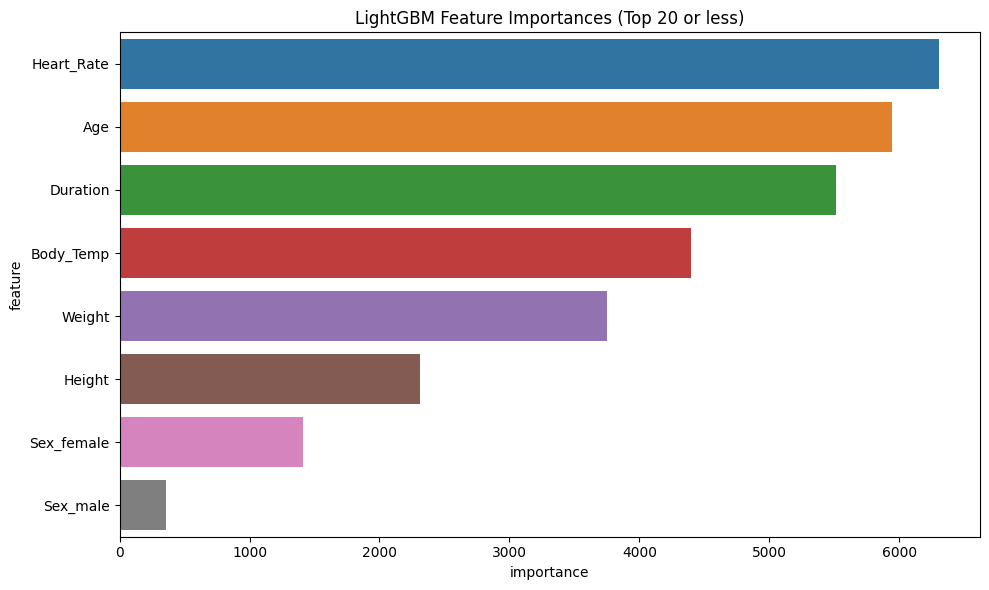


Top Feature Importances:
      feature  importance
4  Heart_Rate        6305
0         Age        5946
3    Duration        5511
5   Body_Temp        4399
2      Weight        3753
1      Height        2312
6  Sex_female        1413
7    Sex_male         361


In [27]:
if hasattr(model, 'feature_importances_') and isinstance(X_train, pd.DataFrame):
    importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, max(6, len(importances['feature']) * 0.3))) # Adjust height based on num features
    sns.barplot(x='importance', y='feature', data=importances.head(min(20, len(importances))))
    plt.title('LightGBM Feature Importances (Top 20 or less)')
    plt.tight_layout()
    plt.show()
    print("\nTop Feature Importances:")
    print(importances.head(10))
elif hasattr(model, 'feature_importances_'):
    print("Feature importances available, but X_train is not a DataFrame. Plotting with generic feature indices.")
    # Basic plot with indices if X_train was not converted back to DataFrame
    importances_values = model.feature_importances_
    sorted_indices = np.argsort(importances_values)[::-1]
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances_values[sorted_indices][:20], y=[f"Feature_{i}" for i in sorted_indices][:20])
    plt.title('LightGBM Feature Importances (Top 20, generic names)')
    plt.show()

# PREDICTION ON TEST SET

In [28]:
print("\nPredicting on the test set...")
test_pred_log = model.predict(X_test_submit)
test_pred_orig = np.expm1(test_pred_log)
test_pred_orig = np.maximum(0, test_pred_orig)

print("Test predictions (first 5):")
print(test_pred_orig[:5])


Predicting on the test set...
Test predictions (first 5):
[ 27.0378818  109.4958423   87.68850998 124.40790431  77.04395984]


# CREATE SUBMISSION FILE

In [29]:
submission_df = pd.DataFrame({'id': test_df['id'], TARGET_COL: test_pred_orig})

print("\nSample submission head:")
print(sample_submission_df.head())
print("\nGenerated submission head:")
print(submission_df.head())

submission_filename = 'submission.csv'
submission_df.to_csv(submission_filename, index=False, float_format='%.4f') # Format float for consistency
print(f"\nSubmission file '{submission_filename}' created successfully.")

print("\n--- Notebook Execution Finished ---")


Sample submission head:
       id  Calories
0  750000    88.283
1  750001    88.283
2  750002    88.283
3  750003    88.283
4  750004    88.283

Generated submission head:
       id    Calories
0  750000   27.037882
1  750001  109.495842
2  750002   87.688510
3  750003  124.407904
4  750004   77.043960

Submission file 'submission.csv' created successfully.

--- Notebook Execution Finished ---
